In [112]:
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [108]:
def calculate_Hausholder(v: np.array):
    """
    Helper function to calculate the Hausholder matrix from v.
    
    Parameters
    ----------
    v : np.array
        The given vector. Needs to be normalized prior to passing.
        
    Returns
    -------
    H : np.ndarray
        The Hausholder matrix of v.
    """
    
    H = np.identity(max(v.shape)) - 2*np.outer(v, v)
    return H


def my_qr(A: np.ndarray):
        """
        Returns the QR factorization of a nonsingular array
        via (classical) Gram-Schmidt.

        Parameters
        ----------
        A: np.ndarray
            The matrix with which we find the QR factorization.
            Must be nonsingular, sized n x n

        Returns
        -------
        Q: np.ndarray
            A set of orthonormal column vectors of size n x n

        R: np.ndarray
            An upper triangular matrix
        """
        m, n = A.shape
        Q = np.zeros((m, m))
        R = np.zeros((m, n))

        for i in range(0, m): #Row Iter
            prev = 0 # used to catch r_{jk}q_j in sum
            for j in range(0, i+1): # maintain upper triangularity
                if i != j:
                    R[j, i] = np.dot(Q[:, j], A[:, i])
                    prev += R[j, i] * Q[:, j]
                else: #Diagonal term, take prev
                    R[i, i] = np.linalg.norm(A[:, i] - prev, ord = 2)
                    assert R[i, i] != 0, "Diagonal is zero, function cannot continue"
                    Q[:, j] = (1/R[i, i]) * (A[:, i] - prev)
    
        return Q, R
    
def hausholder_qr(A: np.ndarray):
    """
        Returns the QR factorization obtained through 
        the Hausholder Reflection method. 
        
        Elements belonging to and above diagonal are R, 
        
        Below the diagonal are the column vectors v_1, ..., v_n-1
        which are used to get Q_1, ..., Q_n-1. 
        
        Last element of v_i is not stored. Can be recovered since 
        v is a unit vector.
    """
    m, n = A.shape
    v_mat = []
    for i in range(m-1):
        
        # Obtaining v_i
        u = A[i:, i].copy()
        u[0] -= np.linalg.norm(u, ord = 2)
        v = u/np.linalg.norm(u, ord = 2)
        
        v_mat.append(v)

        #Calculating Q only to get next iteration
        Q = np.identity(m)
        Q[i:, i:] = calculate_Hausholder(v)
        
        A = np.matmul(Q, A)

    #Storing v_i's
    for i in range(m-1):
        A[i+1:, i] = np.array(v_mat[i])[:-1]
        
    return A

def recover_Qis(A: np.ndarray):
    """
    Calculates all Q_is from a Hausholder applied matrix A.
    
    Parameters
    ----------
    
    A : np.ndarray
        The matrix on which Hausholder QR has been performed
        
    Returns
    -------
    Qis : list(np.ndarray)
        A list containing all Q's 
    """
    Qis = []
    
    m, n = A.shape
    
    for i in range(m - 1):
        v = np.zeros(m - i)
        v[1:] = A[i+1:, i].copy()
        v[0] = np.sqrt(1 - np.linalg.norm(v, ord = 2)**2)
        Q = np.identity(m)
        Q[i:, i:] = calculate_Hausholder(v)
        Qis.append(Q)
    
    return Qis

def calculate_Q(A: np.ndarray):
    """
    Returns the orthonormal matrix Q from the matrix A after Hausholder QR 
    is applied.
    
    Parameters
    ----------
    
    A : np.ndarray
        The matrix on which Hausholder QR has been performed

    Returns
    -------    
    
    Q: np.ndarray
        The orthonormal matrix involved in QR
    """
    
    Qis = recover_Qis(A.copy())
    Q = np.identity(Qis[0].shape[0])
    for Qi in Qis:
        Q = np.matmul(Q, Qi.T)
        
    return Q

"""
My functions:
------------
my_qr: Gram schmidt, gives back Q and R in tuple
hausholder_qr: gives back R and v's 
"""

In [30]:
A = np.array([[12, -51, 4],
                [6, 167, -68],
                [-4, 24, -41]])

B = hausholder_qr(A)
Q = calculate_Q(B)
Q

array([[ 0.42857143, -0.74285714,  0.51428571],
       [ 0.28571429,  0.65142857,  0.70285714],
       [-0.85714286, -0.15428571,  0.49142857]])

In [71]:
def Rel_error(A : np.ndarray, B : np.ndarray) -> float:
    """
    Helper function to calculate the relative error of two matrices.
    Relative error is taken with respect to A, and with the 
    Frobenius norm
    """
    
    num = np.linalg.norm(A - B, ord='fro')
    den = np.linalg.norm(A, ord = 'fro')
    return num * (1/den)

In [126]:
maxsize = 1000
iterations = 100

i = 0

#Result array. 
#Size Quantity x iterations x number of functions
res = np.ndarray((4, iterations, 2))

for n in range(int(maxsize/iterations), maxsize +1 , int(maxsize/iterations)):
    
    
    #Temporary array to store quantities. 
    #Only holds one set of Quants at a time. 
    res_arr = np.zeros(4)
    
    #Get a random upper triangular matrix. Size will increase
    R = np.triu(np.random.default_rng().normal(10, 2.5, size=(n, n)))

    # Get a random matrix.
    B = np.random.default_rng().normal(10, 2.5, size=(n, n))
    Q = np.linalg.qr(B)[0]

    #Form A = QR
    A = np.matmul(Q, R)
    
    #Identity matrix
    I = np.identity(n)
    
    #QR from the Gram schmidt QR
    GS_Q, GS_R = my_qr(A)

    #Forward Errors for GS
    GS_A = np.matmul(GS_Q, GS_R)
    GS_I = np.matmul(GS_Q.T, GS_Q)
    
    #QR from HausHolder QR
    HH = hausholder_qr(A)
    HH_Q = calculate_Q(HH)
    HH_R = np.triu(HH)
    
    #Forward errors for HH
    HH_A = np.matmul(HH_Q, HH_R)
    HH_I = np.matmul(HH_Q.T, HH_Q)

    #Calcualting relative error for GS
    res_arr = np.array([Rel_error(R, GS_R), 
                        Rel_error(Q, GS_Q), 
                        Rel_error(A, GS_A), 
                        Rel_error(I, GS_I) 
                        ])
    
    #Storing GS results for iteration 
    res[:, i, 0] = res_arr
    
    #Calculating relative error for HH
    res_arr = np.array([Rel_error(R, HH_R),
                        Rel_error(Q, HH_Q),
                        Rel_error(A, HH_A),
                        Rel_error(I, HH_I)])
    
    #Storing HH results for iteration
    res[:, i, 1] = res_arr
    
    #Incrementing for next iteration
    i+=1
    
    #Clearing output
    clear_output(wait=True)
    
    print("Percentage done: {:.2f}%".format(100*n/maxsize))

Percentage done: 100.00%


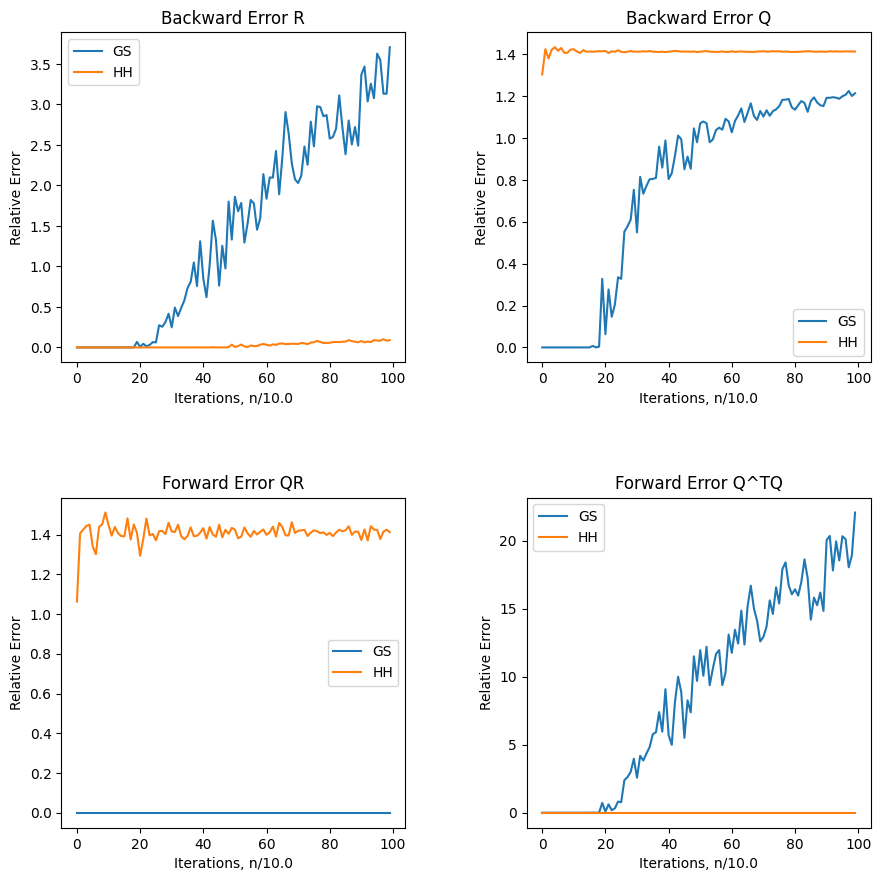

In [131]:
Titles = ["Backward Error R", "Backward Error Q", "Forward Error QR", "Forward Error Q^TQ"]
method = ["GS", "HH"]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        index = i * 2 + j
        ax[i, j].set_title(Titles[index])
        
        for k in range(2):
            ax[i, j].plot(res[index, :, k], label=method[k])
            ax[i, j].legend()
            
        ax[i, j].set_xlabel(f'Iterations, n/{maxsize / iterations}')
        ax[i, j].set_ylabel("Relative Error")

plt.tight_layout(pad=5.0)
plt.show()